In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark.sql.functions as F
from pyspark.ml.recommendation import ALS

/home/hadoop/IPythonNB/venv/local/lib64/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Goal

Goal of this competition is to: 
* predict the booking outcome (hotel cluster) for a user event
* based on their search and other attributes associated with that user event

# Load data

### Training data 

The train and test datasets are split based on time: training data from 2013 and 2014, while test data are from 2015

The training data includes both click and booking events

Expedia has provided you logs of customer behavior. These include : 
* Destination Hotel Location
  * hotel_continent, hotel_country, hotel_market, hotel_cluster
* Hotel id
  * srch_destination_id
  * hotel_cluster
* Details of stay
  * booking time range
      * srch_ci
      * srch_co
  * room size
      * srch_adults_cnt
      * srch_children_cnt
  * srch_rm_cnt
  * is_package
* User's Search origin
  * user_id and their location
* User's Search details
  * channel 
    * referrer (Direct, SEM , Meta channel like trip advisor)
  * site name ID.  (Expedia domain name)
  * is_mobile
  * cnt
    * number of similar events in the context of the same user search
* how they interacted with search results (is_booking), 
* Distance between hotel and customer performing search
  * orig_destination_distance (geodesic distance in miles)

hotel details
* hotel_cluster
  * Expedia has in-house algorithms to form hotel clusters, where similar hotels for a search (based on historical price, customer star ratings, geographical locations relative to city center, etc) are grouped together
  * These hotel clusters serve as good identifiers to which types of hotels people are going to book, while avoiding outliers such as new hotels that don't have historical data

In [2]:
# Define file paths and data schemas

trainingText = sc.textFile('s3n://uwong.expedia.hotel/training_data/train.csv.gz')

# Parse text into RDDs

trainingData = (trainingText
    .map(lambda x: x.split('\n'))
    .map(lambda x: x[0].split(','))
)

# Save column header
columnNames = trainingData.first()

dfTrainingData = (trainingData
    .filter(lambda x: x != columnNames) # remove header
    .toDF(columnNames)
)

dfTrainingData.show()

+-------------------+---------+--------------+---------------------+--------------------+------------------+-------------------------+-------+---------+----------+-------+----------+----------+---------------+-----------------+-----------+-------------------+------------------------+----------+---+---------------+-------------+------------+-------------+
|          date_time|site_name|posa_continent|user_location_country|user_location_region|user_location_city|orig_destination_distance|user_id|is_mobile|is_package|channel|   srch_ci|   srch_co|srch_adults_cnt|srch_children_cnt|srch_rm_cnt|srch_destination_id|srch_destination_type_id|is_booking|cnt|hotel_continent|hotel_country|hotel_market|hotel_cluster|
+-------------------+---------+--------------+---------------------+--------------------+------------------+-------------------------+-------+---------+----------+-------+----------+----------+---------------+-----------------+-----------+-------------------+------------------------+--

In [43]:
(dfTrainingData
 .filter(dfTrainingData['user_id'] == 12)
 .select()
 ).show()

+-------------------+---------+--------------+---------------------+--------------------+------------------+-------------------------+-------+---------+----------+-------+----------+----------+---------------+-----------------+-----------+-------------------+------------------------+----------+---+---------------+-------------+------------+-------------+
|          date_time|site_name|posa_continent|user_location_country|user_location_region|user_location_city|orig_destination_distance|user_id|is_mobile|is_package|channel|   srch_ci|   srch_co|srch_adults_cnt|srch_children_cnt|srch_rm_cnt|srch_destination_id|srch_destination_type_id|is_booking|cnt|hotel_continent|hotel_country|hotel_market|hotel_cluster|
+-------------------+---------+--------------+---------------------+--------------------+------------------+-------------------------+-------+---------+----------+-------+----------+----------+---------------+-----------------+-----------+-------------------+------------------------+--

### Destinations data (srch_destination_id)

destinations.csv data consists of features extracted from hotel reviews text. 

Note that some srch_destination_id's in the train/test files don't exist in the destinations.csv file. This is because some hotels are new and don't have enough features in the latent space. Your algorithm should be able to handle this missing information.

In [12]:
# 2.5 million rows
# Id's are unique

destinationsText = sc.textFile('s3n://uwong.expedia.hotel/destinations.csv.gz')

# Parse text into RDDs

destinationsData = (destinationsText
    .map(lambda x: x.split('\n'))
    .map(lambda x: x[0].split(','))
)

# Save column header
columnNames = destinationsData.first()

dfDestinationsData = (destinationsData
    .filter(lambda x: x != columnNames) # remove header
    .toDF(columnNames)
)

dfDestinationsData.show()

+-------------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+----

In [8]:
dfDestinationsData.select('id').distinct().count()

2528243

### Test data from 2015

Only includes booking events

In [3]:
# Define file paths and data schemas

testingText = sc.textFile('s3n://uwong.expedia.hotel/testing_data/test.csv.gz')

# Parse text into RDDs

testingData = (testingText
    .map(lambda x: x.split('\n'))
    .map(lambda x: x[0].split(','))
)

# Save column header
columnNames = testingData.first()

dfTestingData = (testingData
    .filter(lambda x: x != columnNames) # remove header
    .toDF(columnNames)
)

dfTestingData.show()

+---+-------------------+---------+--------------+---------------------+--------------------+------------------+-------------------------+-------+---------+----------+-------+----------+----------+---------------+-----------------+-----------+-------------------+------------------------+---------------+-------------+------------+
| id|          date_time|site_name|posa_continent|user_location_country|user_location_region|user_location_city|orig_destination_distance|user_id|is_mobile|is_package|channel|   srch_ci|   srch_co|srch_adults_cnt|srch_children_cnt|srch_rm_cnt|srch_destination_id|srch_destination_type_id|hotel_continent|hotel_country|hotel_market|
+---+-------------------+---------+--------------+---------------------+--------------------+------------------+-------------------------+-------+---------+----------+-------+----------+----------+---------------+-----------------+-----------+-------------------+------------------------+---------------+-------------+------------+
|  0

In [19]:
# One row per distinct id (user)
dfTestingData.count()

2528243

In [10]:
print(dfTrainingData.columns)
print(dfDestinationsData.columns)
print(dfTestingData.columns)

[u'date_time', u'site_name', u'posa_continent', u'user_location_country', u'user_location_region', u'user_location_city', u'orig_destination_distance', u'user_id', u'is_mobile', u'is_package', u'channel', u'srch_ci', u'srch_co', u'srch_adults_cnt', u'srch_children_cnt', u'srch_rm_cnt', u'srch_destination_id', u'srch_destination_type_id', u'is_booking', u'cnt', u'hotel_continent', u'hotel_country', u'hotel_market', u'hotel_cluster']
[u'id', u'date_time', u'site_name', u'posa_continent', u'user_location_country', u'user_location_region', u'user_location_city', u'orig_destination_distance', u'user_id', u'is_mobile', u'is_package', u'channel', u'srch_ci', u'srch_co', u'srch_adults_cnt', u'srch_children_cnt', u'srch_rm_cnt', u'srch_destination_id', u'srch_destination_type_id', u'hotel_continent', u'hotel_country', u'hotel_market']
[u'id', u'date_time', u'site_name', u'posa_continent', u'user_location_country', u'user_location_region', u'user_location_city', u'orig_destination_distance', u'u

### Submission example

a sample submission file in the correct format.

For every 
* user event

predict 
* a space-delimited list of the hotel clusters they booked. 
* You may submit up to 5 predictions for each user event. 

The file should contain a header and have the following format:
* id,hotel_cluster
* 0,99 3 1 75 20
* 1,2 50 30 23 9
* etc...

In [16]:
# Define file paths and data schemas

submissionExampleText = sc.textFile('s3n://uwong.expedia.hotel/sample_submission.csv.gz')

# Parse text into RDDs

submissionExampleData = (submissionExampleText
    .map(lambda x: x.split('\n'))
    .map(lambda x: x[0].split(','))
)

# Save column header
columnNames = submissionExampleData.first()

dfSubmissionExampleData = (submissionExampleData
    .filter(lambda x: x != columnNames) # remove header
    .toDF(columnNames)
)

dfSubmissionExampleData.show()

+---+-------------+
| id|hotel_cluster|
+---+-------------+
|  0|         99 1|
|  1|         99 1|
|  2|         99 1|
|  3|         99 1|
|  4|         99 1|
|  5|         99 1|
|  6|         99 1|
|  7|         99 1|
|  8|         99 1|
|  9|         99 1|
| 10|         99 1|
| 11|         99 1|
| 12|         99 1|
| 13|         99 1|
| 14|         99 1|
| 15|         99 1|
| 16|         99 1|
| 17|         99 1|
| 18|         99 1|
| 19|         99 1|
+---+-------------+
only showing top 20 rows



# Take a small sample of the users

The training data set has:
* 37 million rows
* 1,198,786 distinct users

In [20]:
# Take a smaller sample for faster debugging
# dfTrainingSample = dfTrainingData.sample(withReplacement=False, fraction=0.01, seed=42)
# dfTrainingSample.cache()
# dfTrainingSample.registerTempTable('training_data')

In [84]:
# numTrainingUsers = dfTrainingData.select('user_id').distinct().count()
# print('Number of distinct users = %i' % numTrainingUsers)

Nunber of distinct users = 1198786


In [89]:
dfSampleUsers = dfTrainingData.select('user_id').distinct().sample(withReplacement=False, fraction=0.01, seed=42)
# dfTrainingUsers, dfValidationUsers = dfTrainingData.randomSplit(weights=[2.0, 1.0], seed=24)
dfSampleUsers.show()

+-------+
|user_id|
+-------+
| 100340|
| 556084|
| 783712|
|1088450|
|  96951|
| 685540|
|1178397|
| 515700|
|1099304|
|1014299|
| 318132|
|1101823|
|1030543|
| 317692|
|  52904|
| 646688|
|1129337|
| 852553|
| 770743|
| 509590|
+-------+
only showing top 20 rows



In [91]:
dfTrainingSample, dfValidationSample = dfSampleUsers.randomSplit(weights=[60.0, 40.0], seed=24)
dfTrainingSample.registerTempTable('training_data')
dfValidationSample.registerTempTable('validation_data')

# Transform data to count bookings and clicks by user_id and hotel_cluster

In [21]:
# For each booking row

dfBookings = (dfTrainingSample
                    .filter(dfTrainingSample.is_booking == 1)
                    .groupBy(['user_id', 'hotel_cluster'])
                    .agg(F.count('is_booking').alias('num_bookings'))
              )
dfBookings.show()

# Join the number of preceding clicks 

+-------+-------------+------------+
|user_id|hotel_cluster|num_bookings|
+-------+-------------+------------+
|   9681|           10|           1|
| 984866|            0|           1|
| 290737|           83|           1|
|1071051|           55|           1|
|  62715|           84|           1|
|1179625|            6|           1|
| 752345|           16|           1|
| 923249|           15|           1|
|1050946|           46|           1|
|1122693|           98|           1|
| 696651|           93|           1|
| 957456|            5|           1|
|1135134|           18|           1|
| 475007|           48|           1|
| 486791|            6|           1|
|1163824|            8|           1|
|1171755|           42|           1|
| 706751|           43|           1|
| 757479|           51|           1|
| 281372|           97|           1|
+-------+-------------+------------+
only showing top 20 rows



In [22]:
dfBookings.select('num_bookings').describe().show()

+-------+-------------------+
|summary|       num_bookings|
+-------+-------------------+
|  count|              30096|
|   mean| 1.0042530568846357|
| stddev|0.06558631971482612|
|    min|                  1|
|    max|                  3|
+-------+-------------------+



In [23]:
dfClicks = (dfTrainingSample
            .filter(dfTrainingSample.is_booking == 0)
            .groupBy(['user_id', 'hotel_cluster'])
            .agg(F.count('is_booking').alias('num_clicks'))
            )
dfClicks.show()

+-------+-------------+----------+
|user_id|hotel_cluster|num_clicks|
+-------+-------------+----------+
|  79449|           62|         1|
| 336165|           69|         1|
| 371436|           50|         1|
| 424798|           41|         1|
| 504802|           91|         1|
| 529397|           26|         1|
| 648800|           65|         1|
| 839406|           45|         1|
| 851556|           72|         1|
| 878160|           36|         1|
| 878177|           30|         1|
| 925128|            8|         1|
| 943187|           41|         1|
|1014934|           65|         1|
|1113858|            4|         1|
|1114710|           55|         1|
|1125822|           17|         1|
| 154433|           34|         1|
| 197671|           55|         1|
| 232939|            9|         2|
+-------+-------------+----------+
only showing top 20 rows



In [24]:
dfClicks.select('num_clicks').describe().show()

+-------+------------------+
|summary|        num_clicks|
+-------+------------------+
|  count|            338365|
|   mean|1.0250646491215107|
| stddev|0.1675635222518101|
|    min|                 1|
|    max|                 9|
+-------+------------------+



In [25]:
dfEvents = (dfTrainingSample
            .filter(dfTrainingSample.is_booking == 0)
            .groupBy(['user_id', 'hotel_cluster'])
            .agg(F.sum('cnt').cast('int').alias('num_events'))
            )
dfEvents.show()

+-------+-------------+----------+
|user_id|hotel_cluster|num_events|
+-------+-------------+----------+
|  79449|           62|         2|
| 336165|           69|         1|
| 371436|           50|         1|
| 424798|           41|         1|
| 504802|           91|         2|
| 529397|           26|         1|
| 648800|           65|         2|
| 839406|           45|         1|
| 851556|           72|         1|
| 878160|           36|         2|
| 878177|           30|         1|
| 925128|            8|         1|
| 943187|           41|         1|
|1014934|           65|         4|
|1113858|            4|         1|
|1114710|           55|         1|
|1125822|           17|         1|
| 154433|           34|         1|
| 197671|           55|         1|
| 232939|            9|         2|
+-------+-------------+----------+
only showing top 20 rows



In [26]:
dfEvents.select('num_events').describe().show()

+-------+------------------+
|summary|        num_events|
+-------+------------------+
|  count|            338365|
|   mean|1.5619818834690349|
| stddev|1.3152200598415302|
|    min|                 1|
|    max|                85|
+-------+------------------+



In [27]:
dfBookingClicks = (dfBookings
                  .join(dfClicks, 
#                         on=(dfBookings.user_id == dfClicks.user_id) & (dfBookings.hotel_cluster == dfClicks.hotel_cluster), 
                        on=['user_id', 'hotel_cluster'],
                        how='outer')
                   .select('user_id', 'hotel_cluster', 'num_bookings', 'num_clicks')
                  )

dfBookingClicksEvents = (dfBookingClicks
                         .join(dfEvents, 
                            on=['user_id', 'hotel_cluster'],
                            how='outer')
                         .select('user_id', 'hotel_cluster', 'num_bookings', 'num_clicks', 'num_events')
                         .na.fill(0)
                        )
dfBookingClicksEvents.show()

+-------+-------------+------------+----------+----------+
|user_id|hotel_cluster|num_bookings|num_clicks|num_events|
+-------+-------------+------------+----------+----------+
| 100043|           10|           0|         1|         1|
|1000652|            5|           0|         1|         1|
|1000900|           41|           0|         1|         1|
|1000922|           52|           0|         1|         3|
|1001129|           98|           0|         1|         1|
| 100119|           30|           0|         1|         1|
|1001870|            4|           0|         1|         1|
|1002113|           63|           1|         0|         0|
|1002213|           11|           0|         1|         1|
|1002577|           47|           0|         1|         1|
|1002991|           10|           0|         1|         1|
| 100317|           85|           1|         0|         0|
|  10033|           82|           0|         1|         2|
|1003560|           28|           1|         0|         

# Create rating columns that combines bookings and clicks into a single value

In [28]:
bookingWeight = 5
dfBookingClicksEventsRating = (dfBookingClicksEvents
                               .withColumn('rating', 
                                           bookingWeight * dfBookingClicksEvents.num_bookings +  dfBookingClicksEvents.num_events)
                               )
dfBookingClicksEventsRating.show()

+-------+-------------+------------+----------+----------+------+
|user_id|hotel_cluster|num_bookings|num_clicks|num_events|rating|
+-------+-------------+------------+----------+----------+------+
| 100043|           10|           0|         1|         1|     1|
|1000652|            5|           0|         1|         1|     1|
|1000900|           41|           0|         1|         1|     1|
|1000922|           52|           0|         1|         3|     3|
|1001129|           98|           0|         1|         1|     1|
| 100119|           30|           0|         1|         1|     1|
|1001870|            4|           0|         1|         1|     1|
|1002113|           63|           1|         0|         0|     5|
|1002213|           11|           0|         1|         1|     1|
|1002577|           47|           0|         1|         1|     1|
|1002991|           10|           0|         1|         1|     1|
| 100317|           85|           1|         0|         0|     5|
|  10033| 

In [29]:
dfBookingClicksEventsRating.select('num_bookings', 'num_clicks', 'num_events', 'rating').describe().show()

+-------+-------------------+-------------------+------------------+------------------+
|summary|       num_bookings|         num_clicks|        num_events|            rating|
+-------+-------------------+-------------------+------------------+------------------+
|  count|             366966|             366966|            366966|            366966|
|   mean|0.08236185368671757| 0.9451720322863698|1.4402424202787178|1.8520516887123057|
| stddev|0.27619132684466996|0.31843627788468115|1.3305333150436633|1.6012965927943605|
|    min|                  0|                  0|                 0|                 1|
|    max|                  3|                  9|                85|                85|
+-------+-------------------+-------------------+------------------+------------------+



# Evaluation

### Calculate Mean Average Precision @ 5

The evaluation criteria is described here:
* https://www.kaggle.com/c/expedia-hotel-recommendations/details/evaluation
* https://www.kaggle.com/wiki/MeanAveragePrecision

$MAP@5 = \frac{1}{|U|}\sum_{u=1}^{|U|}\sum_{k=1}^{min(5,n)}P(k)$
where 
* |U| is the number of user events
* P(k) precision at cutoff k in the item list
* n is the number of predicted hotel clusters per user

Explanation:
1. for each user event
  * over all their events in the data set
    * up to 5 predictions are made

Submission csv file format:

id,hotel_cluster

0,99 3 1 75 20

1,2 50 30 23 9

Explanation:
* https://www.kaggle.com/c/FacebookRecruiting/forums/t/2002/alternate-explanation-of-mean-average-precision

In [ ]:
def read_file_relevant( filename ):
  """Reads a file that contains only relevant IDs"""
  with open( filename ) as inFile:
     inFile.readline() #ignore header
     relevantIDs = set( [line.strip() for line in inFile] )
  return relevantIDs

def APatK ( predictedFileName, relevantIDsFileName, K ):
  """Calculates AP@k given a file with IDs
  sorted in order of relevance and a file with the 
  relevant IDs"""

  relevantIDs = read_file_relevant( relevantIDsFileName )

  with open( predictedFileName) as predictedFile:
    predictedFile.readline() #ignore header
    countRelevants = 0
    listOfPrecisions = list()
    for i, line in enumerate(predictedFile):
      currentk = i + 1.0
      if line.strip() in relevantIDs:
        countRelevants += 1
      precisionAtK = countRelevants / currentk 
      listOfPrecisions.append(precisionAtK)
      if currentk == K:
        break

  return sum( listOfPrecisions ) / K 

In [47]:
def calculatePrecision(numTruePositivePredictions, numActualTrue):
    '''Precision = true positives / (true positives + false positives)
    '''
    result = 0.0
    if min(numTruePositivePredictions, numActualTrue):
        result = float(numTruePositivePredictions / numActualTrue)
    return result

def calculateMAP(U, n=5):
    ''' Calculate the Mean Average Precision Metric @ numPredictions
    
    Inputs:
    ==============
    df -- spark dataframe containing user_events, predictions and list of actual conversions
    U -- the number of user events
    n -- the number of predicted hotel clusters per user
    '''
    result = 0.0
    
    for user
    
    
    
    return result

calculateMAP()

0.0

In [49]:
import numpy as np

def apk(actual, predicted, k=5):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [54]:
print apk(range(1,6),[6,4,7,1,2], 2)
print apk(range(1,6),[1,1,1,1,1], 5)

print mapk([[1,3,4],[1,2,4],[1,3]],
            [range(1,6),range(1,6),range(1,6)], 3)

0.25
0.2
0.685185185185


# Create Evaluation data

For each user in the training data create a list of users and the cluster they actually booked

In [63]:
dfTrainingBooked = (dfTrainingSample
                    .filter(dfTrainingSample.is_booking == 1)
                    .groupBy('user_id')
                    .agg(F.collect_list('hotel_cluster').alias('booked_clusters'))
                    )

In [64]:
dfTrainingBooked.show()

+-------+---------------+
|user_id|booked_clusters|
+-------+---------------+
|1006162|           [64]|
|1006937|           [10]|
|1008719|            [1]|
|1014794|           [46]|
|1016576|           [94]|
|1016620|           [25]|
|1023253|           [41]|
|1038950|           [58]|
|1041235|           [37]|
|1041686|           [51]|
|1045132|           [33]|
|1058101|           [95]|
| 106632|           [41]|
|1068966|           [91]|
|1071908|           [15]|
|1083662|            [6]|
|1084058|           [32]|
|1086830|           [36]|
| 108865|           [91]|
|1095902|           [19]|
+-------+---------------+
only showing top 20 rows



In [67]:
type(dfTrainingBooked)

pyspark.sql.dataframe.DataFrame

In [68]:
dfTrainingBooked.first()

Row(user_id=u'1006162', booked_clusters=[u'64'])

In [83]:
(dfTrainingBooked
    .map(lambda x: pyspark.sql.Row(user_id = x['user_id'], 
                                   observed_booked_clusters = x['booked_clusters'], 
                                   observed_num_bookings = len(x['booked_clusters'])))
    .toDF()
    .filter(pyspark.sql.functions.col('observed_num_bookings') > 3)
 ).show()

+------------------------+---------------------+-------+
|observed_booked_clusters|observed_num_bookings|user_id|
+------------------------+---------------------+-------+
|         [2, 85, 97, 30]|                    4| 215180|
|        [11, 69, 98, 11]|                    4|1104571|
|        [91, 16, 48, 49]|                    4|   4717|
|        [51, 51, 76, 39]|                    4| 604890|
|    [51, 48, 91, 91, 94]|                    5| 976033|
|        [16, 42, 42, 48]|                    4| 634134|
|         [6, 91, 94, 48]|                    4| 415680|
|        [46, 58, 37, 97]|                    4| 921547|
|        [70, 86, 69, 23]|                    4| 468527|
|        [13, 90, 82, 28]|                    4| 341680|
|        [59, 46, 68, 70]|                    4|1094462|
+------------------------+---------------------+-------+



# Fit the recommender model


### Insert a cross validation step to tune the hyper parameters of the recommender

In [30]:
als = ALS(rank=10, maxIter=5, implicitPrefs=True,
                          userCol="user_id", itemCol="hotel_cluster", ratingCol="rating")
recommendationModel = als.fit(dfBookingClicksEventsRating)

# Examine predictions made onto the same training data

In [31]:
# predict the 'ratings' (num_clicks) a user will make for each 
dfPredictions = recommendationModel.transform(dfBookingClicksEventsRating)

In [32]:
dfPredictionsSorted = (dfPredictions
                       .orderBy('prediction', ascending=False))
dfPredictionsSorted.show()

+-------+-------------+------------+----------+----------+------+----------+
|user_id|hotel_cluster|num_bookings|num_clicks|num_events|rating|prediction|
+-------+-------------+------------+----------+----------+------+----------+
| 162829|           91|           0|         1|         1|     1| 1.1169686|
| 833494|           91|           0|         1|         1|     1| 1.1070814|
|  33538|           28|           0|         1|         1|     1| 1.0259063|
|  88157|           91|           0|         1|         1|     1| 1.0172715|
|1131821|           91|           0|         1|         1|     1| 1.0108634|
| 639825|           91|           1|         0|         0|     5|0.99835503|
| 276322|           91|           0|         1|         1|     1| 0.9849627|
|1028531|           91|           0|         1|         1|     1|0.98127776|
| 670783|           91|           2|         0|         0|    10|0.97944266|
| 178854|           91|           0|         1|         8|     8| 0.9778323|

In [33]:
dfPredictionsSorted.select('prediction').describe().show()

+-------+------------------+
|summary|        prediction|
+-------+------------------+
|  count|            366966|
|   mean|0.2723516863434247|
| stddev| 0.173163094203429|
|    min|       -0.53418314|
|    max|         1.1169686|
+-------+------------------+



# Evaluate the predictions

See if there is a correlation between the prediction we made and bookings, clicks, and combined rating

In [34]:
# Using pandas!

pdPredictions = dfPredictionsSorted.toPandas()

In [35]:
pdPredictions.head()

,user_id,hotel_cluster,num_bookings,num_clicks,num_events,rating,prediction
0,162829,91,0,1,1,1,1.116969
1,833494,91,0,1,1,1,1.107081
2,33538,28,0,1,1,1,1.025906
3,88157,91,0,1,1,1,1.017272
4,1131821,91,0,1,1,1,1.010863


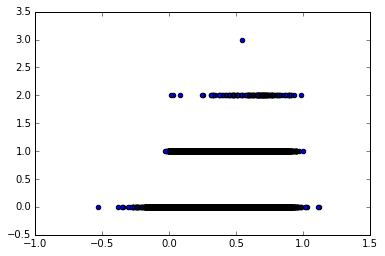

In [36]:
plt.scatter(pdPredictions.prediction, pdPredictions.num_bookings)

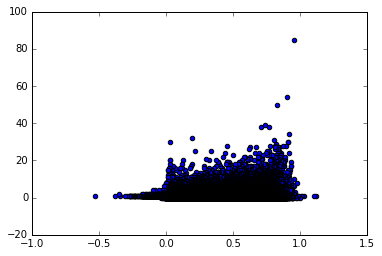

In [37]:
plt.scatter(pdPredictions.prediction, pdPredictions.num_events)

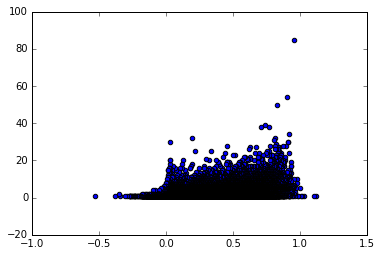

In [38]:
plt.scatter(pdPredictions.prediction, pdPredictions.rating)

# Prediction score vs. Number of click events for each hotel cluster

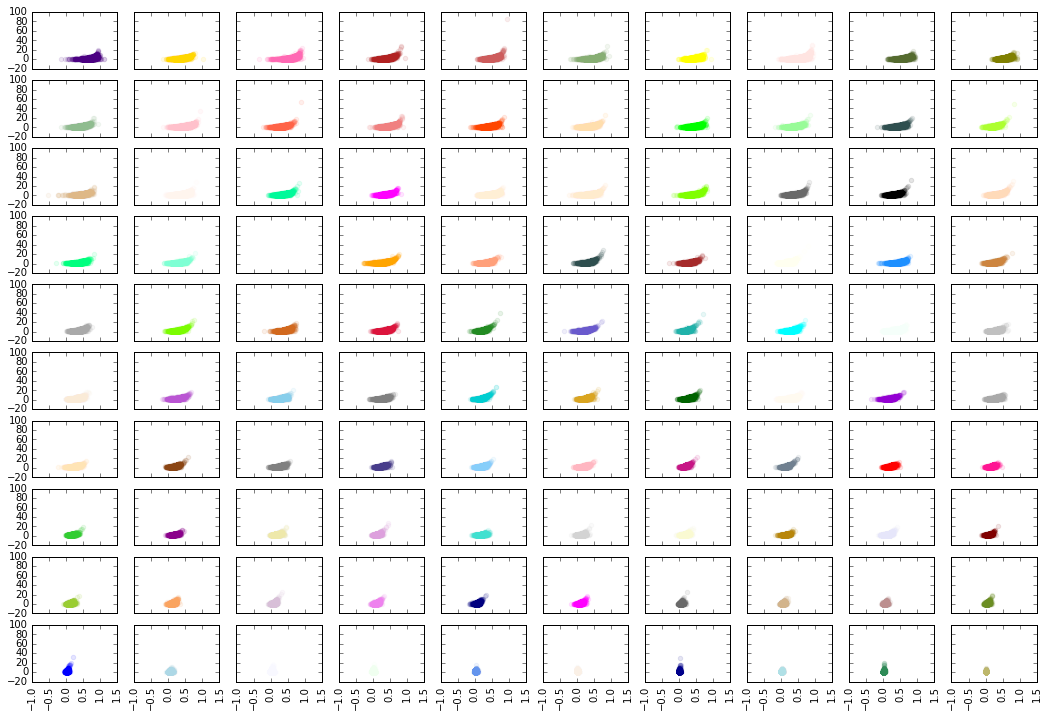

In [39]:
from matplotlib import colors
hotelList = pdPredictions.hotel_cluster.unique().tolist()
colorMap = colors.cnames.keys()
numRows = 10
numCols = 10
fig, ax = plt.subplots(nrows=numRows, ncols=numCols, figsize=(18,12), sharex=True, sharey=True)
for i, hotel in enumerate(hotelList):
    ix = i / numRows
    iy = i % numCols
#     print('%i, %i' % (ix, iy))
    plotData = pdPredictions.loc[pdPredictions.hotel_cluster == hotel]
    ax[ix][iy].scatter(plotData.prediction, plotData.rating, alpha=0.1, color = colorMap[i % len(colorMap)])
    
# plt.set_xlabel('Prediction')
# plt.set_ylabel('Number of click events + 5xnum_bookings')
    
for i in range(numRows):
    for j in range(numCols):

#         ax[i].set_xlabel('Time of commute start')
#         ax[i].set_ylabel('Duration in traffic (minutes)')

#         ax[i].set_ylim([40, 110])

#         ax[i].xaxis.set_visible(True)
#         ax[i].yaxis.set_visible(True)

        for tick in ax[i][j].get_xticklabels():
            tick.set_rotation(90)

## Prediction score vs. Number of Bookings for each hotel cluster

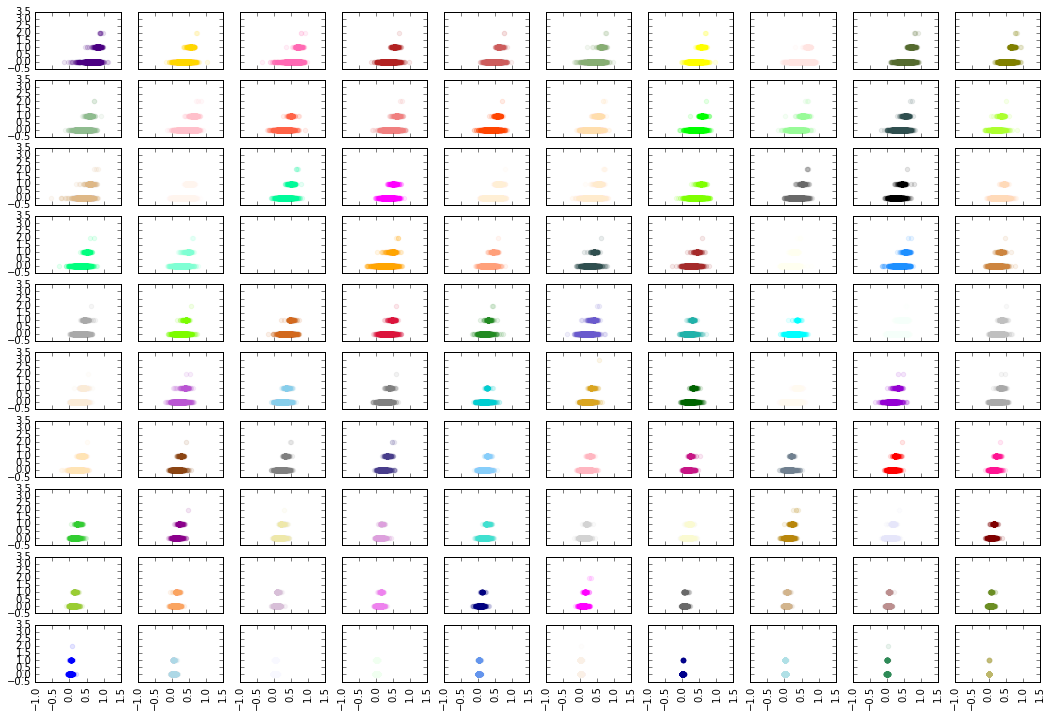

In [40]:
from matplotlib import colors
hotelList = pdPredictions.hotel_cluster.unique().tolist()
colorMap = colors.cnames.keys()
numRows = 10
numCols = 10
fig, ax = plt.subplots(nrows=numRows, ncols=numCols, figsize=(18,12), sharex=True, sharey=True)
for i, hotel in enumerate(hotelList):
    ix = i / numRows
    iy = i % numCols
#     print('%i, %i' % (ix, iy))
    plotData = pdPredictions.loc[pdPredictions.hotel_cluster == hotel]
    ax[ix][iy].scatter(plotData.prediction, plotData.num_bookings, alpha=0.1, color = colorMap[i % len(colorMap)])
    
# plt.set_xlabel('Prediction')
# plt.set_ylabel('Number of click events + 5xnum_bookings')
    
for i in range(numRows):
    for j in range(numCols):

#         ax[i].set_xlabel('Time of commute start')
#         ax[i].set_ylabel('Duration in traffic (minutes)')

#         ax[i].set_ylim([40, 110])

#         ax[i].xaxis.set_visible(True)
#         ax[i].yaxis.set_visible(True)

        for tick in ax[i][j].get_xticklabels():
            tick.set_rotation(90)

# Output results to S3

In [41]:
pdPredictions.shape

(366966, 7)

In [42]:
outputPath = 's3n://uwong.expedia.hotel/output/'
outputFile = 'recommendations.csv'

# Export spark dataframe?
dfPredictionsSorted.save(outputPath+outputFile)

/usr/lib/spark/python/pyspark/sql/dataframe.py:167: UserWarning: insertInto is deprecated. Use write.save() instead.
  warnings.warn("insertInto is deprecated. Use write.save() instead.")


AnalysisException: u'path s3n://uwong.expedia.hotel/output/recommendations.csv already exists.;'